# Load libs

In [1]:
import pandas as pd
import numpy as np

import pygraphviz as pgv
from pgmpy.models.BayesianNetwork import BayesianNetwork
from pgmpy.estimators import MaximumLikelihoodEstimator
from pgmpy.metrics import correlation_score
from pgmpy.metrics import log_likelihood_score
from pgmpy.inference import VariableElimination
from pgmpy.estimators import BayesianEstimator
from pgmpy.factors.discrete import TabularCPD

from datetime import datetime

from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

import os
import pprint

from IPython.display import Image
import matplotlib.pyplot as plt

import ipywidgets as widgets
from IPython.display import display

import networkx as nx
import matplotlib.pyplot as plt
from pgmpy.readwrite import BIFReader


# Load data

In [2]:
df = pd.read_csv('./data/dummy_data.csv')
print(df.head())

         date  temperature month seasons  rain  sunlight  wind  mood  walk  \
0  2020-01-01            1   Jan  Winter     0         1    23   -31     1   
1  2020-01-02           -9   Jan  Winter     0         1    21   -22     0   
2  2020-01-03            2   Jan  Winter     0         1    20   -22     1   
3  2020-01-04           -2   Jan  Winter     0         1    22   -24     0   
4  2020-01-05            0   Jan  Winter     0         1    15    15     1   

  temperature_category      wind_category mood_category  
0                 cold  4 moderate breeze    0 very bad  
1            very cold  4 moderate breeze         1 bad  
2                 cold    3 gentle breeze         1 bad  
3            very cold  4 moderate breeze         1 bad  
4            very cold    3 gentle breeze        3 good  


## Convert the date into date, time format

In [3]:
# Convert 'date' column to datetime format
df['date'] = pd.to_datetime(df['date'])

df_to_print = df.copy()

# Print the dataframe to verify the conversion
df.head()

,date,temperature,month,seasons,rain,sunlight,wind,mood,walk,temperature_category,wind_category,mood_category
0,2020-01-01,1,Jan,Winter,0,1,23,-31,1,cold,4 moderate breeze,0 very bad
1,2020-01-02,-9,Jan,Winter,0,1,21,-22,0,very cold,4 moderate breeze,1 bad
2,2020-01-03,2,Jan,Winter,0,1,20,-22,1,cold,3 gentle breeze,1 bad
3,2020-01-04,-2,Jan,Winter,0,1,22,-24,0,very cold,4 moderate breeze,1 bad
4,2020-01-05,0,Jan,Winter,0,1,15,15,1,very cold,3 gentle breeze,3 good


## Drop unecessary columns

In [4]:
df.columns

Index(['date', 'temperature', 'month', 'seasons', 'rain', 'sunlight', 'wind',
       'mood', 'walk', 'temperature_category', 'wind_category',
       'mood_category'],
      dtype='object')

In [5]:
df = df.drop(columns=['temperature', 'wind', 'mood'])

df.columns

Index(['date', 'month', 'seasons', 'rain', 'sunlight', 'walk',
       'temperature_category', 'wind_category', 'mood_category'],
      dtype='object')

## Rename column names for ease

In [6]:
df.rename(columns=lambda x: x.replace('_category', ''), inplace=True)
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1886 entries, 0 to 1885
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         1886 non-null   datetime64[ns]
 1   month        1886 non-null   object        
 2   seasons      1886 non-null   object        
 3   rain         1886 non-null   int64         
 4   sunlight     1886 non-null   int64         
 5   walk         1886 non-null   int64         
 6   temperature  1886 non-null   object        
 7   wind         1886 non-null   object        
 8   mood         1886 non-null   object        
dtypes: datetime64[ns](1), int64(3), object(5)
memory usage: 132.7+ KB
None


## Method to process data

In [7]:
def process_new_data(new_df):
    new_df = new_df.drop(columns=['temperature', 'wind', 'mood', 'date', 'month'])
    new_df.rename(columns=lambda x: x.replace('_category', ''), inplace=True)
    new_df = new_df.apply(lambda x: x.astype('category'))
    new_df.info()

    return new_df

# BNN

## drop columns not used

In [8]:
df = df.drop(columns=['date', 'month'])
df.columns

Index(['seasons', 'rain', 'sunlight', 'walk', 'temperature', 'wind', 'mood'], dtype='object')

## Create Bayesian network

In [9]:
# Define the structure of the Bayesian Network
model = BayesianNetwork([
    ('seasons', 'temperature'),
    ('seasons', 'wind'),
    ('seasons', 'rain'),
    ('seasons', 'sunlight'),
    ('temperature', 'walk'),
    ('rain', 'mood'),
    ('sunlight', 'mood'),
    ('wind', 'walk'),
    ('temperature', 'rain'),
    ('wind', 'rain'),
    ('temperature', 'sunlight'),
    ('wind', 'sunlight'),
    ('mood', 'walk')
])

# Print the model to verify the structure
print(model.edges())

[('seasons', 'temperature'), ('seasons', 'wind'), ('seasons', 'rain'), ('seasons', 'sunlight'), ('temperature', 'walk'), ('temperature', 'rain'), ('temperature', 'sunlight'), ('wind', 'walk'), ('wind', 'rain'), ('wind', 'sunlight'), ('rain', 'mood'), ('sunlight', 'mood'), ('mood', 'walk')]


## Visualize the network

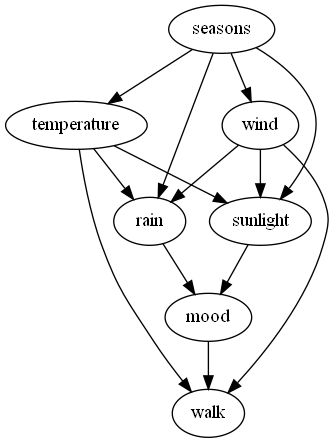

In [10]:
# Save the network as an image
model.to_graphviz().draw('./images/model_1_bn.png', prog='dot')

# Display the network in the notebook
Image(filename='./images/model_1_bn.png')

## Train the model

In [11]:
print(df.dtypes)

seasons        object
rain            int64
sunlight        int64
walk            int64
temperature    object
wind           object
mood           object
dtype: object


In [12]:
# Convert all columns to categorical type
df = df.apply(lambda x: x.astype('category'))

# Print the dataframe to verify the conversion
print(df.dtypes)

seasons        category
rain           category
sunlight       category
walk           category
temperature    category
wind           category
mood           category
dtype: object


In [27]:
print(df.describe())

       seasons  rain  sunlight  walk temperature             wind    mood
count     1886  1886      1886  1886        1886             1886    1886
unique       4     2         2     2           4                7       5
top     Winter     0         1     1        cold  3 gentle breeze  3 good
freq       511  1781      1781  1499         751              405     572


In [13]:
seasons_categories = df['seasons'].unique()
print(f"Categories of seasons: {seasons_categories}")
print(f"Number of categories: {len(seasons_categories)}")

Categories of seasons: ['Winter', 'Spring', 'Summer', 'Autumn']
Categories (4, object): ['Autumn', 'Spring', 'Summer', 'Winter']
Number of categories: 4


In [14]:
# Train the model using Maximum Likelihood Estimation
model.fit(df, estimator=MaximumLikelihoodEstimator)

# Predict the 'walk' variable
predicted_walk = model.predict(df.drop(columns=['walk']))
print(predicted_walk)

  0%|          | 0/104 [00:00<?, ?it/s]

      walk
0        1
1        0
2        0
3        0
4        1
...    ...
1881     1
1882     0
1883     0
1884     1
1885     1

[1886 rows x 1 columns]


In [15]:
# Check the model for any errors or inconsistencies
model.check_model()

True

## Save the model

In [16]:
# Create the directory if it doesn't exist
if not os.path.exists('./model/'):
    os.makedirs('./model/')

# Get the current date and time
now = datetime.now().strftime('%Y%m%d_%H%M%S')

# Define the model columns
model_columns = df.columns.tolist()

# Define the filename with parameters and date & time
model_filename = f"./model/bayesian_network_{'_'.join([f'{col}_{model_columns[i]}' 
                                                 for i, col in enumerate(model_columns)])}_{now}.bif"

# Save the model in BIF format
model.save(model_filename, filetype='bif')

print(f"Model saved as {model_filename}")


Model saved as ./model/bayesian_network_seasons_seasons_rain_rain_sunlight_sunlight_walk_walk_temperature_temperature_wind_wind_mood_mood_20250304_113449.bif


# Look at model stats

## Accuracy & precision

In [17]:
# Calculate accuracy
accuracy = accuracy_score(df['walk'], predicted_walk['walk'])
print(f"Accuracy: {accuracy}")

# Calculate precision
precision = precision_score(df['walk'], predicted_walk['walk'])
print(f"Precision: {precision}")

# Calculate recall
recall = recall_score(df['walk'], predicted_walk['walk'])
print(f"Recall: {recall}")

# Calculate F1-score
f1 = f1_score(df['walk'], predicted_walk['walk'])
print(f"F1-score: {f1}")

Accuracy: 0.83881230116649
Precision: 0.9222614840989399
Recall: 0.8705803869246164
F1-score: 0.8956760466712422


C:\Users\adhav\AppData\Local\Temp\ipykernel_19568\2510599963.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  monthly_metrics = df_to_print.groupby('month').apply(lambda x: pd.Series({


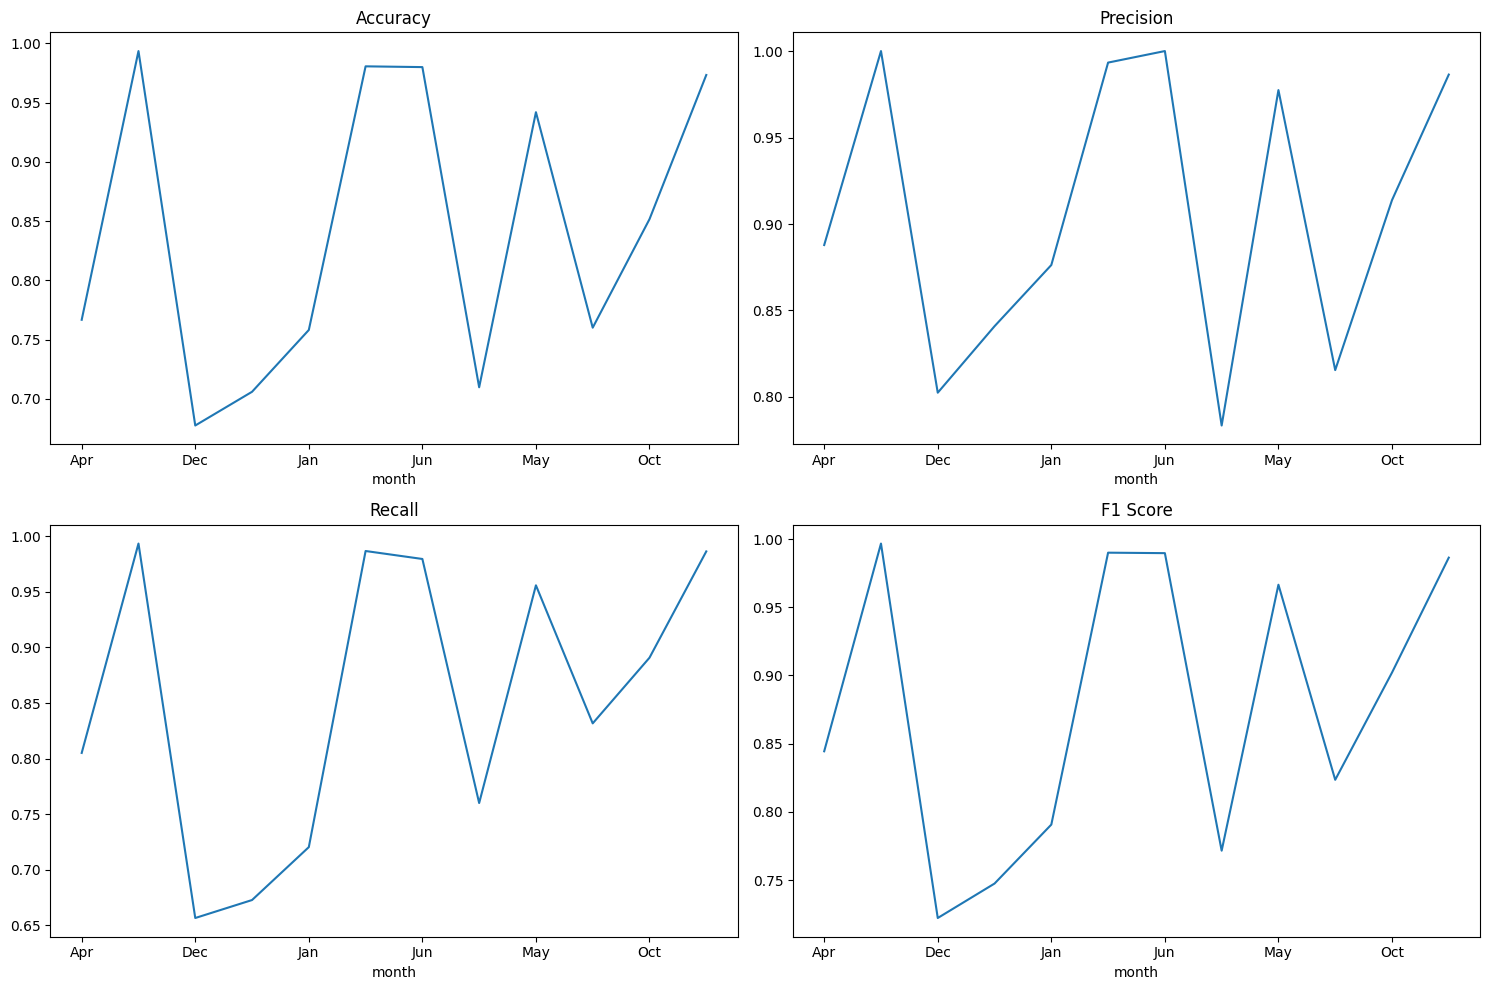

In [18]:
# Group by month and calculate performance metrics
monthly_metrics = df_to_print.groupby('month').apply(lambda x: pd.Series({
    'accuracy': accuracy_score(x['walk'].dropna(), predicted_walk.loc[x.index]['walk']),
    'precision': precision_score(x['walk'].dropna(), predicted_walk.loc[x.index]['walk']),
    'recall': recall_score(x['walk'].dropna(), predicted_walk.loc[x.index]['walk']),
    'f1_score': f1_score(x['walk'].dropna(), predicted_walk.loc[x.index]['walk'])
}))

# Plot the metrics
fig, ax = plt.subplots(2, 2, figsize=(15, 10))

monthly_metrics['accuracy'].plot(ax=ax[0, 0], title='Accuracy')
monthly_metrics['precision'].plot(ax=ax[0, 1], title='Precision')
monthly_metrics['recall'].plot(ax=ax[1, 0], title='Recall')
monthly_metrics['f1_score'].plot(ax=ax[1, 1], title='F1 Score')

plt.tight_layout()
plt.show()

## Correlation

`model` (Instance of pgmpy.base.DAG or pgmpy.models.BayesianNetwork) – The model which needs to be tested.

`data` (pandas.DataFrame instance) – The dataset against which to test the model structure.

`test` (str or function) – The statistical tests to use for determining whether the variables in data are correlated or not. For discrete variables, the options are: 1) chi_square 2) g_sq 3) log_likelihood 4) freeman_tuckey 5) modified_log_likelihood 6) neyman 7) cressie_read. For continuous variables only one test is available: 1) pearsonr. A function with the signature fun(X, Y, Z, data) can also be passed which returns True for uncorrelated and False otherwise.

`significance_level` (float) – A value between 0 and 1. If p_value < significance_level, the variables are considered uncorrelated.

`score` (function (default: f1-score)) – Any classification scoring metric from scikit-learn. https://scikit-learn.org/stable/modules/classes.html#classification-metrics

In [19]:
data_corr = model.simulate(int(1e4))

# Calculate the correlation score
correlation = correlation_score(model, data_corr, test='chi_square', significance_level=0.05, return_summary=True)

print(f"Correlation Score: {correlation}")

  0%|          | 0/7 [00:00<?, ?it/s]

Correlation Score:            var1         var2  stat_test  d_connected
0       seasons  temperature      False        False
1       seasons         wind      False        False
2       seasons         rain      False        False
3       seasons     sunlight      False        False
4       seasons         walk      False        False
5       seasons         mood      False        False
6   temperature         wind      False        False
7   temperature         rain      False        False
8   temperature     sunlight      False        False
9   temperature         walk      False        False
10  temperature         mood      False        False
11         wind         rain      False        False
12         wind     sunlight      False        False
13         wind         walk      False        False
14         wind         mood      False        False
15         rain     sunlight      False        False
16         rain         walk      False        False
17         rain         moo

c:\Users\adhav\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Log likelyhood

The log-likelihood measure can be used to check how well the specified model describes the data. This method requires the parameters of the model to be specified as well. Direct interpretation of this score is difficult but can be used to compare the fit of two or more models. A higher score means a better fit.

In [20]:
log_likelyhood = log_likelihood_score(model, df)
log_likelyhood

np.float64(-10098.885392811371)

## Get the Conditional Probability Distribution

In [21]:
cpds = model.get_cpds()
pprint.pp(cpds)

[<TabularCPD representing P(seasons:4) at 0x25bf351c050>,
 <TabularCPD representing P(temperature:4 | seasons:4) at 0x25bee4a8850>,
 <TabularCPD representing P(wind:7 | seasons:4) at 0x25b960d6550>,
 <TabularCPD representing P(rain:2 | seasons:4, temperature:4, wind:7) at 0x25bf33fb5c0>,
 <TabularCPD representing P(sunlight:2 | seasons:4, temperature:4, wind:7) at 0x25bf33fb980>,
 <TabularCPD representing P(walk:2 | mood:5, temperature:4, wind:7) at 0x25bf34e60b0>,
 <TabularCPD representing P(mood:5 | rain:2, sunlight:2) at 0x25bf34e5ef0>]


In [22]:
# Create the directory if it doesn't exist
if not os.path.exists('./cpds/'):
    os.makedirs('./cpds/')

# Iterate through each CPD and save it as a CSV file
for i, cpd in enumerate(cpds):
    cpd_df = pd.DataFrame(cpd.get_values())
    if len(cpd.variables) > 1:
        cpd_df.columns = [f"{cpd.variables[1]}({j})" for j in range(cpd_df.shape[1])]
    else:
        cpd_df.columns = [f"{cpd.variables[0]}({j})" for j in range(cpd_df.shape[1])]
    cpd_df.index = [f"{cpd.variables[0]}({j})" for j in range(cpd_df.shape[0])]
    cpd_df.to_csv(f'./cpds/cpd_{i}.csv')
    print(f'Saved CPD {i} to ./cpds/cpd_{i}.csv')

Saved CPD 0 to ./cpds/cpd_0.csv
Saved CPD 1 to ./cpds/cpd_1.csv
Saved CPD 2 to ./cpds/cpd_2.csv
Saved CPD 3 to ./cpds/cpd_3.csv
Saved CPD 4 to ./cpds/cpd_4.csv
Saved CPD 5 to ./cpds/cpd_5.csv
Saved CPD 6 to ./cpds/cpd_6.csv


In [81]:
cpd_seasons = model.get_cpds('seasons')
cpd_temp = model.get_cpds('temperature')
cpd_wind = model.get_cpds('wind')
cpd_sunlight = model.get_cpds('sunlight')
cpd_rain = model.get_cpds('rain')
cpd_mood = model.get_cpds('mood')
cpd_walk = model.get_cpds('walk')

In [82]:
cpd_seasons.to_csv('./cpds/cpd_seasons.csv')
cpd_temp.to_csv('./cpds/cpd_temp.csv')
cpd_wind.to_csv('./cpds/cpd_wind.csv')
cpd_sunlight.to_csv('./cpds/cpd_sunlight.csv')
cpd_rain.to_csv('./cpds/cpd_rain.csv')
cpd_mood.to_csv('./cpds/cpd_mood.csv')
cpd_walk.to_csv('./cpds/cpd_walk.csv')

### CPD fot seasons

In [ ]:
for cpd in model.get_cpds():
    print(f"Variable: {cpd.variable}")
    print(f"Cardinality: {cpd.cardinality}")
    print(cpd)
    print("\n")

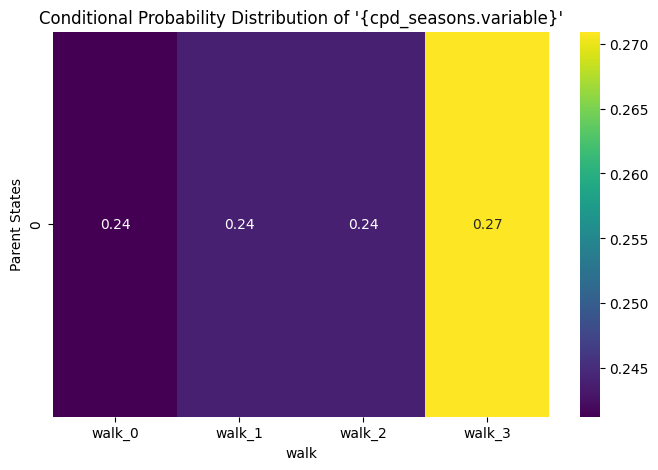

In [71]:
cpd_seasons = model.get_cpds('seasons')

# Convert CPD values to a 2D array
cpd_values_2d = cpd_seasons.values.reshape(-1, cpd_seasons.cardinality[0])

# Create a DataFrame for the heatmap
df_cpd = pd.DataFrame(cpd_values_2d, columns=[f'walk_{i}' for i in range(cpd_seasons.cardinality[0])])

# Plot heatmap
plt.figure(figsize=(8, 5))
sns.heatmap(df_cpd, annot=True, cmap="viridis", fmt=".2f")
plt.title("Conditional Probability Distribution of '{cpd_seasons.variable}'")
plt.xlabel("walk")
plt.ylabel("Parent States")
plt.show()


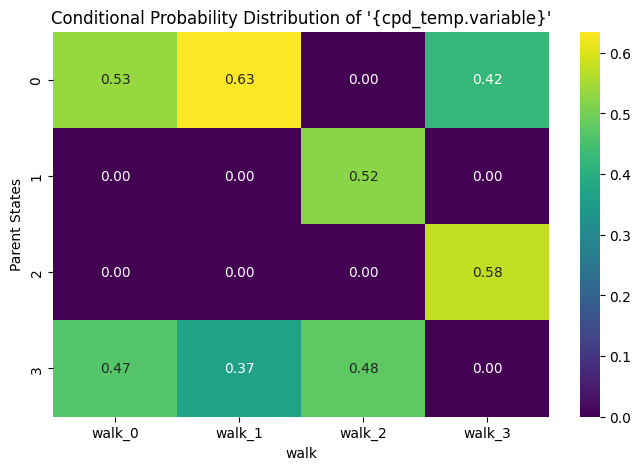

In [72]:
# Extract CPD for the node 'walk'
cpd_temp = model.get_cpds('temperature')

# Convert CPD values to a 2D array
cpd_values_2d = cpd_temp.values.reshape(-1, cpd_temp.cardinality[0])

# Create a DataFrame for the heatmap
df_cpd = pd.DataFrame(cpd_values_2d, columns=[f'walk_{i}' for i in range(cpd_temp.cardinality[0])])

# Plot heatmap
plt.figure(figsize=(8, 5))
sns.heatmap(df_cpd, annot=True, cmap="viridis", fmt=".2f")
plt.title("Conditional Probability Distribution of '{cpd_temp.variable}'")
plt.xlabel("walk")
plt.ylabel("Parent States")
plt.show()


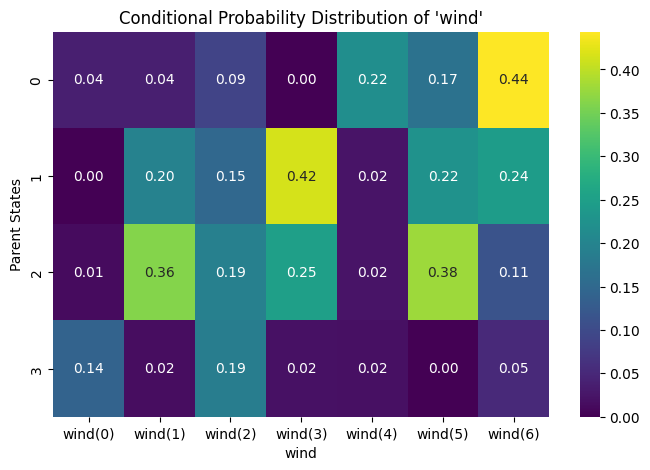

In [73]:
# Extract CPD for the node
cpd_wind = model.get_cpds('wind')

# Convert CPD values to a 2D array
cpd_values_2d = cpd_wind.values.reshape(-1, cpd_wind.cardinality[0])

# Create a DataFrame for the heatmap
df_cpd = pd.DataFrame(cpd_values_2d, columns=[f"{cpd_wind.variable}({i})" for i in range(cpd_wind.cardinality[0])])

# Plot heatmap
plt.figure(figsize=(8, 5))
sns.heatmap(df_cpd, annot=True, cmap="viridis", fmt=".2f")
plt.title(f"Conditional Probability Distribution of '{cpd_wind.variable}'")
plt.xlabel(f"{cpd_wind.variable}")
plt.ylabel(f"Parent States")
plt.show()


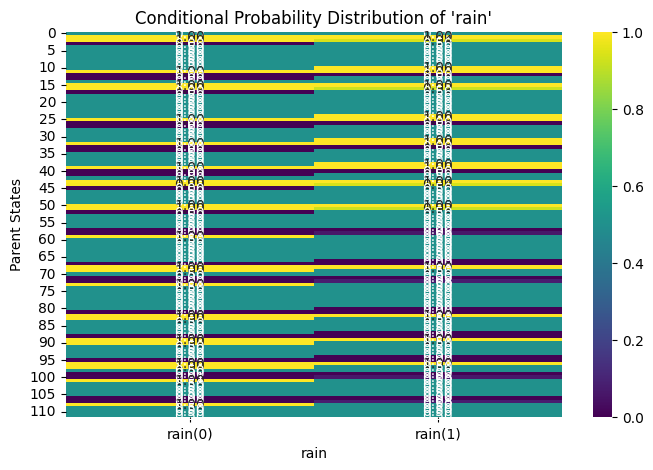

In [74]:
# Extract CPD for the node
cpd_rain = model.get_cpds('rain')

# Convert CPD values to a 2D array
cpd_values_2d = cpd_rain.values.reshape(-1, cpd_rain.cardinality[0])

# Create a DataFrame for the heatmap
df_cpd = pd.DataFrame(cpd_values_2d, columns=[f"{cpd_rain.variable}({i})" for i in range(cpd_rain.cardinality[0])])

# Plot heatmap
plt.figure(figsize=(8, 5))
sns.heatmap(df_cpd, annot=True, cmap="viridis", fmt=".2f")
plt.title(f"Conditional Probability Distribution of '{cpd_rain.variable}'")
plt.xlabel(f"{cpd_rain.variable}")
plt.ylabel(f"Parent States")
plt.show()


In [75]:
pprint.pprint(cpd_rain)

<TabularCPD representing P(rain:2 | seasons:4, temperature:4, wind:7) at 0x25bf33fb5c0>


In [76]:
cpd_rain.variable_card

2

In [78]:
print(cpd_rain.values)

[[[[0.5        0.5        1.         1.         1.         0.93877551
    0.        ]
   [0.5        0.5        0.5        0.5        0.5        0.5
    0.5       ]
   [0.5        0.5        0.5        0.5        0.5        0.5
    0.5       ]
   [1.         1.         1.         0.         0.         0.
    0.5       ]]

  [[0.5        0.5        1.         1.         1.         0.91803279
    0.        ]
   [0.5        0.5        0.5        0.5        0.5        0.5
    0.5       ]
   [0.5        0.5        0.5        0.5        0.5        0.5
    0.5       ]
   [1.         1.         1.         0.         0.         0.
    0.5       ]]

  [[0.5        0.5        0.5        0.5        0.5        0.5
    0.5       ]
   [1.         1.         1.         0.         0.         0.
    0.5       ]
   [0.5        0.5        0.5        0.5        0.5        0.5
    0.5       ]
   [1.         1.         1.         0.         0.         0.
    0.5       ]]

  [[0.5        0.5        1.        

In [79]:
cpd_rain.to_csv('./cpds/cpd_rain.csv')

use CPDs

In [ ]:
# Create an inference object
inference = VariableElimination(model)

# Perform inference to find the probability of 'walk' given evidence
evidence = {'mood': "very bad", 'rain': 0, 'sunlight': 1, 'temperature': "hot", 'wind': "light breeze"}
result = inference.query(variables=['walk'], evidence=evidence)

# Print the result
print(result)

# Simulate & predict based on new data

## load the new data

In [ ]:
# Load the new data
df_to_predict = pd.read_csv('./data/to_predict_long.csv')
df_to_predict['date'] = pd.to_datetime(df_to_predict['date'])
df_to_predict.head()

## process new data

In [ ]:
# Process the new data using the process_new_data method
df_to_predict_processed = process_new_data(df_to_predict)

# Print the processed dataframe to verify the changes
print(df_to_predict_processed.head())

## Use the loaded data to predict

In [ ]:
# Make predictions
y_pred = model.predict(df_to_predict_processed.drop(columns=['walk']))

# Calculate metrics
accuracy = accuracy_score(df_to_predict_processed['walk'], y_pred['walk'])
recall = recall_score(df_to_predict_processed['walk'], y_pred['walk'], average='binary')  # Change 'binary' to 'macro' or 'micro' if needed
precision = precision_score(df_to_predict_processed['walk'], y_pred['walk'], average='binary')
f1 = f1_score(df_to_predict_processed['walk'], y_pred['walk'], average='binary')

# Print metrics
print(f'Accuracy: {accuracy:.4f}')
print(f'Recall: {recall:.4f}')
print(f'Precision: {precision:.4f}')
print(f'F1 Score: {f1:.4f}')

## GUI to predict `walk`

methods to categorize the data

In [ ]:
# Define a function to categorize temperature
def categorize_temperature(temp):
    if temp < 0:
        return 'very cold'
    elif 0 < temp <= 10:
        return 'cold'
    elif 10 < temp <= 20:
        return 'warm'
    else:
        return 'hot'
    
# Define a function to categorize temperature
def categorize_wind(wind):
    if wind < 1:
        return 'calm'
    elif 1 < wind <= 5:
        return 'light air'
    elif 6 < wind <= 11:
        return 'light breeze'
    elif 12 < wind <= 20:
        return 'gentle breeze'
    elif 21 < wind <= 28:
        return 'moderate breeze'
    elif 29 < wind <= 38:
        return 'fresh breeze'
    else:
        return 'strong breeze'
    
# Define a function to categorize temperature
def categorize_mood(mood):
    if mood < -25:
        return 'very bad'
    elif -26 < mood <= 0:
        return 'bad'
    elif 0 < mood <= 10:
        return 'okish'
    elif 11 < mood <= 30:
        return 'good'
    else:
        return 'very good'

In [ ]:
# Create sliders for the input variables
temperature_slider = widgets.IntSlider(min=-10, max=40, step=1, description='Temperature')
rain_slider = widgets.IntSlider(min=0, max=1, step=1, description='Rain')
sunlight_slider = widgets.IntSlider(min=0, max=1, step=1, description='Sunlight')
wind_slider = widgets.IntSlider(min=0, max=50, step=1, description='Wind')
mood_slider = widgets.IntSlider(min=-50, max=50, step=1, description='Mood')

temperature_label = widgets.Label(value=categorize_temperature(temperature_slider.value))
wind_label = widgets.Label(value=categorize_wind(wind_slider.value))
mood_label = widgets.Label(value=categorize_mood(mood_slider.value))

# Create a button for prediction
predict_button = widgets.Button(description='Predict if I walk')

# Create an output widget to display the result
output = widgets.Output()

dynamically show labels based on slider

In [ ]:
# Define callback functions to update the labels
def update_temperature_label(change):
    temperature_label.value = categorize_temperature(change['new'])

def update_wind_label(change):
    wind_label.value = categorize_wind(change['new'])

def update_mood_label(change):
    mood_label.value = categorize_mood(change['new'])

# Attach the callback functions to the sliders
temperature_slider.observe(update_temperature_label, names='value')
wind_slider.observe(update_wind_label, names='value')
mood_slider.observe(update_mood_label, names='value')

predict function for the GUI

In [ ]:
# Define the function to be called when the button is clicked
def predict_walk(b):
    # Get the values from the sliders
    temperature = categorize_temperature(temperature_slider.value)
    rain = rain_slider.value
    sunlight = sunlight_slider.value
    wind = categorize_wind(wind_slider.value)
    
    # Create a new instance of data
    new_data = pd.DataFrame([{
        'temperature': temperature,
        'rain': rain,
        'sunlight': sunlight,
        'wind': wind
    }])
    
    # Perform inference to predict 'walk'
    prediction = model.predict(new_data)

    pred_str = "I walk" if prediction['walk'].values[0] == 0 else "I do NOT walk"
    
    # Display the result
    with output:
        output.clear_output()
        print(f"Predicted walk: {pred_str}")
        print(f"Predicted walk: {prediction['walk'].values[0]}")

# Attach the function to the button
predict_button.on_click(predict_walk)

run the GUI

In [ ]:
# Display the widgets
display(temperature_slider, temperature_label, rain_slider, sunlight_slider, wind_slider, 
        wind_label, predict_button, output)